In [16]:
import urllib.request
from datetime import datetime
import re
import json
import os
import sqlite3
from pymystem3 import Mystem
import collections
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import style
from PIL import Image
from wordcloud import WordCloud, ImageColorGenerator


# создаем базу данных
def bd():
    conn = sqlite3.connect('kprf.db')
    c = conn.cursor()
    c.execute('CREATE TABLE IF NOT EXISTS kprf(type TEXT, id TEXT, plain TEXT,length TEXT, lemmas TEXT, year TEXT, month TEXT, city TEXT, closedprofile TEXT, ids TEXT)')
    conn.commit()
    j = 0
    # заполняем базу данных
    while j < 1500:
        req = urllib.request.Request('https://api.vk.com/method/wall.get?owner_id=-26362316&offset=%s&count=2&v=5.92&access_token=e3938235e3938235e39382359ce3f98c72ee393e3938235bf2bb9cee3f71fa739a2e795'% (j))
        j += 10
        response = urllib.request.urlopen(req)
        result = response.read().decode('utf-8')
        data = json.loads(result)
        text = data['response']['items'][1]['date']
        content = data['response']['items'][0]['text']
        post = data['response']['items'][0]['id']
        # общее количество комментов к посту на потом
        com = data['response']['items'][0]['comments']['count']
        ts = int(text)
        month = datetime.utcfromtimestamp(ts).strftime('%m')
        year = datetime.utcfromtimestamp(ts).strftime('%Y')
        # не очень красиво чистим
        words = content.replace('.', '').replace(';', '').replace(',', '').replace('?', '')
        words = words.replace('!', '').replace(':', '').replace('"', ' ')
        words = words.replace('1', ' ').replace('–', ' ').replace('—', ' ').replace('9', '').replace('0', '')
        words = words.replace('-', ' ').replace('  ', ' ').replace('«', '').replace('»', '').replace('2', '').replace('3', '')
        words = words.replace('4', '').replace('5', '').replace('6', '').replace('7', '').replace('8', '').replace('  ', ' ')
        w = len(words.split( ))
        if w != 0:
            path = "." + os.sep + "kprf" + os.sep + "plain"
            if not os.path.exists(path):
                os.makedirs(path)
            file_1 = "%s//%s.txt" % (path, post)
            # записываем пост в файл и лемматизируем
            with open(file_1, 'w', encoding='utf-8') as t:
                t.write(content)
                x = content
                m = Mystem()
                lemmas = m.lemmatize(content)
                y = str(' '.join(lemmas))
                newpath = "." + os.sep + "kprf" + os.sep + "mystem-plain"
                if not os.path.exists(newpath):
                    os.makedirs(newpath)
                file_11 = "%s//%s.txt" % (newpath, post)
                with open(file_11, 'a', encoding='utf-8') as r:
                    for l in lemmas:
                        r.write(l)
            # готовим строку для бд
            ty = 'post'
            ownid = post
            х = content
            le = w
            mi = year
            ni = month
            # эти три параметра будут только у комментариев - город
            # автора, закрыт ли профиль и айди поста, к которому он
            li = 0
            ti = 0
            di = 0
            # вносим строку в бд
            c = conn.cursor()
            c.execute('INSERT INTO kprf VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?)',\
                                  (ty, ownid, x, le, y, mi, ni, li, ti, di))
            conn.commit()
            # скачивааем все комменты для поста
            offset = 0
            while com > 0:
                com -= 100
                req = urllib.request.Request('https://api.vk.com/method/wall.getComments?owner_id=-26362316&post_id=%s&count=100&offset=%s&v=5.92&access_token=e3938235e3938235e39382359ce3f98c72ee393e3938235bf2bb9cee3f71fa739a2e795' % (post, offset))
                response = urllib.request.urlopen(req)
                result = response.read().decode('utf-8')
                offset += 100
                data = json.loads(result)
                file_2 = "%s//%s.comments.txt" % (path, post)
                items = data['response']['items']
                for item in items:
                    try:
                        text = item['text']
                        # записываем комент в файл
                        with open(file_2, 'a', encoding='utf-8') as r:
                            r.write(text + '\n')
                    except KeyError:
                        text = None
                    # пишу все через трай чтобы нигде не вылезли ошибки
                    try:
                        user = item['from_id']
                        comid = item['id']
                        req = urllib.request.Request('https://api.vk.com/method/users.get?user_id=%s&fields=city&v=5.92&access_token=e3938235e3938235e39382359ce3f98c72ee393e3938235bf2bb9cee3f71fa739a2e795' % (user))
                        response = urllib.request.urlopen(req)
                        result = response.read().decode('utf-8')
                        cdata = json.loads(result)
                        status = cdata['response'][0]['is_closed']
                        if 'city' not in (cdata['response'][0]):
                            continue
                        c_city = cdata['response'][0]['city']['title']
                        x = text
                        commlemmas = m.lemmatize(text)
                        y = str(' '.join(commlemmas))
                        newpath = "." + os.sep + "kprf" + os.sep + "mystem-plain"
                        if not os.path.exists(newpath):
                            os.makedirs(newpath)
                        file_21 = "%s//%s.comments.txt" % (newpath, post)
                        # лематизируем комент
                        with open(file_21, 'a', encoding='utf-8') as towrit:
                            for c in commlemmas:
                                towrit.write(c)
                        # готовим строку для бд
                        ty = 'comment'
                        ownid = comid
                        mi = 0
                        ni = 0
                        li = c_city
                        ti = status
                        di = post
                        le = text.replace('.', '').replace(';', '').replace(',', '').replace('?', '')
                        le = le.replace('!', '').replace(':', '').replace('"', ' ')
                        le = le.replace('1', ' ').replace('–', ' ').replace('—', ' ').replace('9', '').replace('0', '')
                        le = le.replace('-', ' ').replace('  ', ' ').replace('«', '').replace('»', '').replace('2', '').replace('3', '')
                        le = le.replace('4', '').replace('5', '').replace('6', '').replace('7', '').replace('8', '').replace('  ', ' ')
                        le = len(le.split( ))
                        # иначе вносит пустые
                        if le != 0:
                            c = conn.cursor()
                            c.execute('INSERT INTO kprf VALUES (?, ?, ?, ?, ?, ?, ?,?,?, ?)',\
                                       (ty, ownid, x, le, y, mi, ni, li, ti, di))
                            conn.commit()
                    except KeyError:
                        pass

In [33]:
def nonlem():
    with open('rus_stopwords.txt', 'r', encoding='utf-8') as r:
        stop = r.read()
    x1 = []
    y = []
    z = []
    q = 0
    #делаем частотный словарь
    allthewords = []
    directory = os.walk('kprf/plain')
    for root, dirs, files in directory:
        for file in files:
            if file.endswith('.txt'):
                path = os.path.join(root, file)
                with open(path, 'r') as t:
                    text = t.read().strip()
                    text = text.replace('.', '').replace(';', '').replace(',', '').replace('?', '')
                    text = text.replace('!', '').replace(':', '').replace('"', ' ').replace('%', '')
                    text = text.replace('1', ' ').replace('–', ' ').replace('—', ' ').replace('9', '').replace('0', '')
                    text = text.replace('-', ' ').replace('  ', ' ').replace('«', '').replace('»', '').replace('2', '').replace('3', '')
                    text = text.replace('4', '').replace('5', '').replace('6', '').replace('7', '').replace('8', '').replace('  ', ' ')
                    text = text.split( )
                    for i in text:
                        if i.lower() not in stop.strip():
                            allthewords.append(i.lower())
    n_d = dict(collections.Counter(allthewords).most_common(20))
    for key, value in n_d.items():
        x1.append(key)
        #это нужно для настройки xticks
        z.append(q)
        q += 1
        y.append(value)
    #рисуем график
    figure1 = plt.figure(1, figsize=(8, 4))
    ax1 = figure1.add_axes([0.1, 0.1, 0.8, 0.8])
    plt.title('Топ 20 нелемматизированных')
    plt.xlabel('Слова')
    plt.xticks(z, x1, rotation=45)
    plt.ylabel('Частота')
    plt.plot(x1, y, c='#3d0734', linewidth=7.0)
    plt.savefig('topnonlemma.png', bbox_inches='tight')
    return stop

In [34]:
def lem(stop):
    x = []
    y = []
    z = []
    q = 0
    allthewords = []
    directory = os.walk('kprf/mystem-plain')
    for root, dirs, files in directory:
        for file in files:
            if file.endswith('.txt'):
                path = os.path.join(root, file)
                with open(path, 'r') as t:
                    text = t.read().strip()
                    text = text.replace('.', '').replace(';', '').replace(',', '').replace('?', '')
                    text = text.replace('!', '').replace(':', '').replace('"', ' ')
                    text = text.replace('1', ' ').replace('–', ' ').replace('—', ' ').replace('9', '').replace('0', '')
                    text = text.replace('-', ' ').replace('  ', ' ').replace('«', '').replace('»', '').replace('2', '').replace('3', '')
                    text = text.replace('4', '').replace('5', '').replace('6', '').replace('7', '').replace('8', '').replace('  ', ' ')
                    text=text.split( )
                    for i in text:
                        if i.lower() not in stop.strip():
                            allthewords.append(i.lower())
    d = dict(collections.Counter(allthewords).most_common(20))
    for key, value in d.items():
        x.append(key)
        z.append(q)
        q += 1
        y.append(value)
    figure2 = plt.figure(2, figsize=(8, 4))
    ax2 = figure2.add_axes([0.1, 0.1, 0.8, 0.8])
    plt.title('Топ 20 лемматизированных')
    plt.xlabel('Слова')
    plt.xticks(z, x, rotation=45)
    plt.ylabel('Частота')
    plt.plot(x, y, c='#3d0734', linewidth=7.0)
    plt.savefig('toplemma.png', bbox_inches='tight')
    return allthewords

In [35]:
def cloud(allthewords):
    x = []
    #нужна скачанная картинка
    comment_mask = np.array(Image.open("sssr.jpg"))
    #100 просто красиво, можно было бы и 30 конечно
    d = dict(collections.Counter(allthewords).most_common(100))  
    for key, value in d.items():
        x.append(key)
    x=str(' '.join(x))
    cloud = WordCloud(background_color="white", max_words=2000, mask=comment_mask).generate(x)

    image_colors = ImageColorGenerator(comment_mask)
    plt.figure(3, figsize=[7,7])
    plt.imshow(cloud.recolor(color_func=image_colors), interpolation="bilinear")
    plt.axis("off")

    plt.show()
    cloud.to_file("post_cloud.png")

/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: Matplo

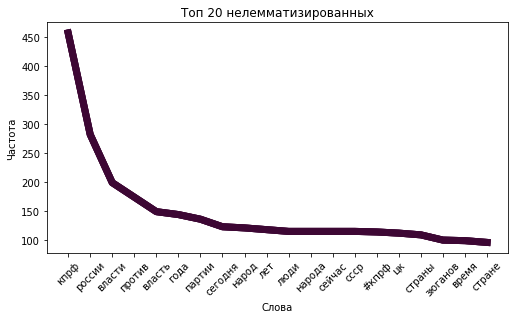

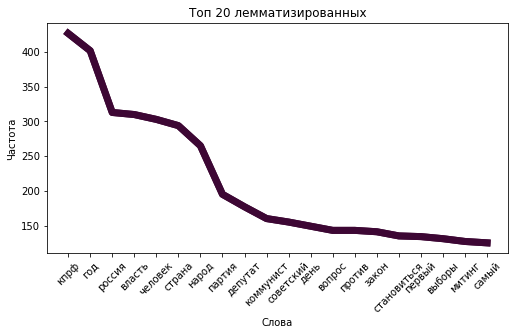

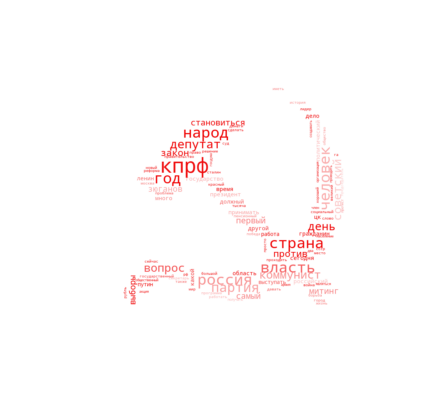

In [36]:
def main():
    bd()
    nonlem()
    lem(nonlem())
    cloud(lem(nonlem()))
    
if __name__ == '__main__':
    main()